<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/finetuning/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is building on top of [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning) keras tutorial and [The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions](https://www.nature.com/articles/sdata2018161) dataset (downloaded from [HAM10000 ImageNet-style dataset](https://www.kaggle.com/umangjpatel/ham10000-imagenet-style-dataset) kaggle dataset). Only small subset of original data is used: class `df` with 115 images, class `vasc` with 142 images and class `akiec` with 327 images.

## Setup


In [1]:
pip install split-folders

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import keras
import splitfolders

## Data preparation

In [5]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

_URL = 'https://github.com/ML-Bioinfo-CEITEC/ECCB2021/raw/finetuning/data/HAM10000/'
PATH = '/content/datasets/HAM10000'
for zip_file in ['akiec.zip', 'df.zip', 'vasc.zip']:
  with urlopen(_URL + zip_file) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
          zfile.extractall(PATH)

In [6]:
splitfolders.ratio(PATH, output=PATH, seed=42, ratio=(.8, .2))

Copying files: 584 files [00:00, 1519.92 files/s]


In [19]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [20]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 466 files belonging to 3 classes.


In [21]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 118 files belonging to 3 classes.


Show the first nine images and labels from the training set:

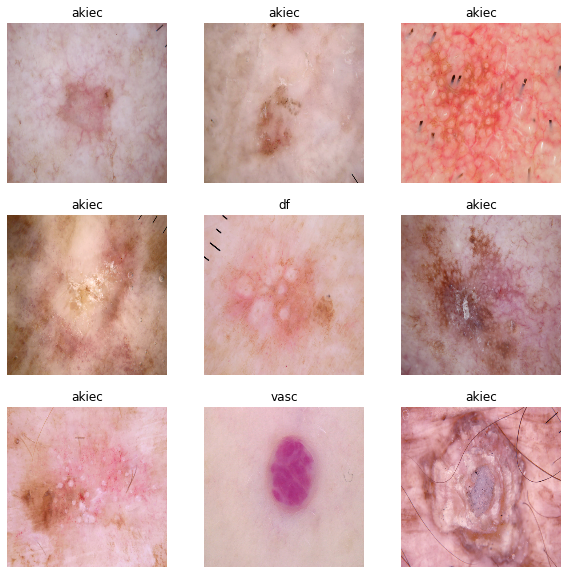

In [22]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation


When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [23]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call model.fit. They are inactive when the model is used in inference mode in model.evaulate or model.fit.

Let's repeatedly apply these layers to the same image and see the result.

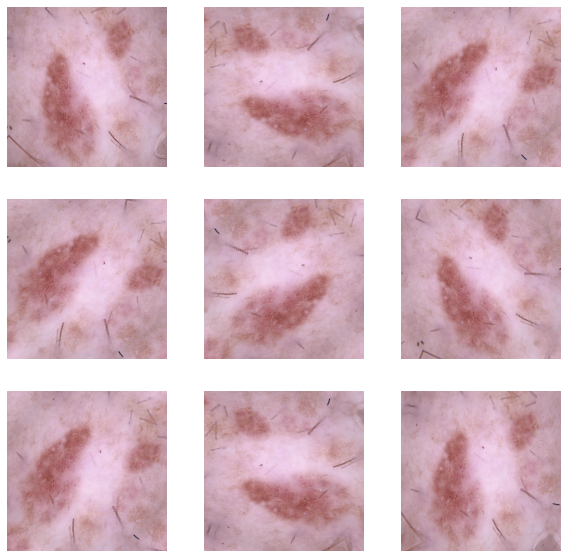

In [24]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')